In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.metrics import accuracy_score

In [15]:
def get_new_df(old_df):
    
    dup_df = pd.DataFrame(data=old_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    dup_df = dup_df.reset_index()
    new_df = pd.merge(old_df.reset_index(), dup_df, how='outer')
    new_df['column_name'] = new_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis = 1)
    
# if x[1]>0 이면 람다식 진행하고, else x[0]이면 x[0]을 출력하라!
    
    new_df.drop(columns=['index'], inplace=True)
    
    return new_df

def get_human_dataset():
    feature_name_df = pd.read_csv('human/human_activity/features.txt', 
            sep='\s+', 
            header=None, 
            names=['column_index','column_name'])
    
    name_df = get_new_df(feature_name_df)
    
    #fBodyAcc-bandsEnergy()-1,8_1을 추출해서 column으로 사용
    feature_name = name_df.iloc[:,1].values.tolist()
    X_train = pd.read_csv('human/human_activity/train/X_train.txt',sep='\s+',names=feature_name) #sep='\s+' : 공백으로 구분
    X_test = pd.read_csv('human/human_activity/test/X_test.txt',sep='\s+',names=feature_name)
    y_train = pd.read_csv('human/human_activity/train/y_train.txt',sep='\s+',names=['action'])
    y_test = pd.read_csv('human/human_activity/test/y_test.txt',sep='\s+',names=['action'])
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [17]:
%%time
gb_clf = GradientBoostingClassifier(random_state=0) # learning_rate=0.1 : 학습률(=얼마큼씩 이동할 지 정하는 값)
gb_clf.fit(X_train,y_train)
pred = gb_clf.predict(X_test)
accuracy_score(y_test,pred)

Wall time: 12min 8s


0.9389209365456397

min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    
    -> dicisiontree기반이라는 것을 알 수 있다.

### XGBoost
트리 기반의 앙상블 학습에서 가장 각광
가적합을 방지하기위한 규제가 가능하다.

◐특징
- 뛰어난 예측 성능
- BGM보다 빠르다.
- 과적합 규제
- TREE PRUNING
- 자체 내장된 교차 검증 : 조기 중단 기능
- 결손값(NA) 자체 처리



### 파이썬 래퍼 XGBoost 하이퍼 파라미터

파이썬 래퍼 XGBoost 모듈과 시이킷런 래퍼 XGBoost 모듈의 일부 하이퍼 파라미터는 약간 다르므로 주의가 필요하다.

- 주요파라미터
booster  
silent  
nthread (n_jobs와 비슷)  

- 주요 부스터 파라미터 
eta
num_boost_rounds(n_estimators와 비슷, 학습기 몇 개를 쓸 것이냐)   
sub_sample(1이면 100%를 쓰겠다.)  
lambda(L2 Regularization)  
aplha(L1 Regularization)  

-교재 231p


In [25]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [24]:
xgb.__version__

'1.5.0'

In [26]:
dataset = load_breast_cancer(as_frame= True)
dataset.data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [28]:
dataset.target_names #'malignant'=악성, 'benign'=양성

array(['malignant', 'benign'], dtype='<U9')

In [29]:
dataset.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [31]:
X_train,X_test,y_train,y_test = train_test_split(dataset.data,dataset.target,test_size=0.2,random_state=156) #학습, 테스트에 쓸 것을 나눔 #stratify=None : 비율설정해서 나눔
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=156)

In [32]:
X_train.shape,X_test.shape

((455, 30), (114, 30))

In [33]:
X_tr.shape,X_val.shape

((409, 30), (46, 30))

In [34]:
y_train.value_counts()

1    280
0    175
Name: target, dtype: int64

In [38]:
dtr = xgb.DMatrix(data=X_tr,label=y_tr)
dval =xgb.DMatrix(data=X_val,label=y_val)
dtest= xgb.DMatrix(data=X_test,label=y_test)

In [ ]:
XGBClassifier() # **kwargs: Any  : kwargs = key word args

In [40]:
#하이퍼파라미터를 딕셔너리로 지정
params = {
    'max_depth' :3,
    'eta' : 0.05,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}
num_rounds = 500 #num_rounds = esimator, 400개 사용하겠다.
eval_list=[(dtr,'train'),(dval,'eval')] #dtr을'train'으로 하겠다.

In [42]:
model = xgb.train(params,dtr,num_rounds,evals=eval_list,early_stopping_rounds=50)#eval = 평가, early_stopping_rounds=None : 조기종료(기간동안 변화가 없을 때 멈춰리)
#train-logloss 점점 줄어든다. eval-logloss는 학습에 사용하지 않아서 줄어들지는 않는다. -> 이 기간을 넘으면 가적합이 됨, 가적합이 되면 오히려 못 맞춘다.

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [43]:
pred_probs = model.predict(dtest)

In [46]:
np.round(pred_probs[:10],3) #1이될 확률

array([0.845, 0.008, 0.68 , 0.081, 0.975, 0.999, 0.998, 0.998, 0.996,
       0.001], dtype=float32)

predict = 확률값, predict_proba = 0,1이 될 확률값이 나온다

In [47]:
pred = [1 if x >0.5 else 0 for x in pred_probs]

In [48]:
pred #결정값

[1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [49]:
def get_clf_eval(y_test,pred,pred_proba_1): #(y_test,pred) 지역변수 pred = 결정값,pred_proba_1=확률값?
    from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,roc_auc_score
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba_1)
    print('오차행렬')
    print(confusion)
    print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, F1:{f1:.4f}, AUC:{auc:.4f}')


In [50]:
 get_clf_eval(y_test,pred,pred_probs)

오차행렬
[[34  3]
 [ 2 75]]
정확도:0.9561, 정밀도:0.9615, 재현율:0.9740, F1:0.9677, AUC:0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

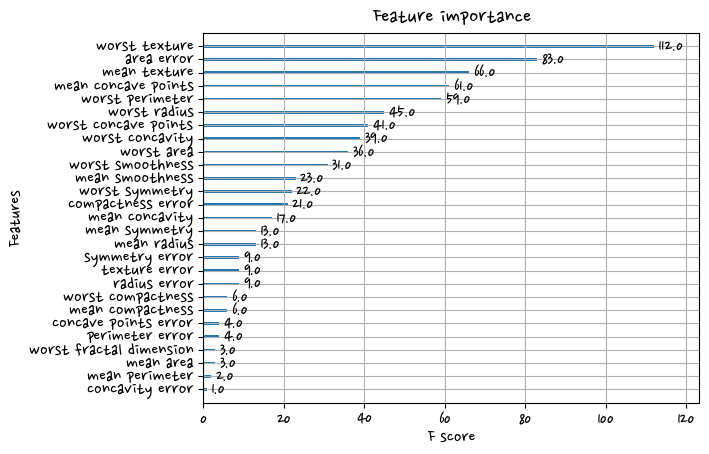

In [51]:
plot_importance(model)

In [52]:
xgb.to_graphviz(model,'xgb.dot')

XGBoostError: [15:32:50] ..\dmlc-core\src\io\local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "xgb.dot": No such file or directory

### 사이킷 래퍼 XGBoost의 개요 및 적용

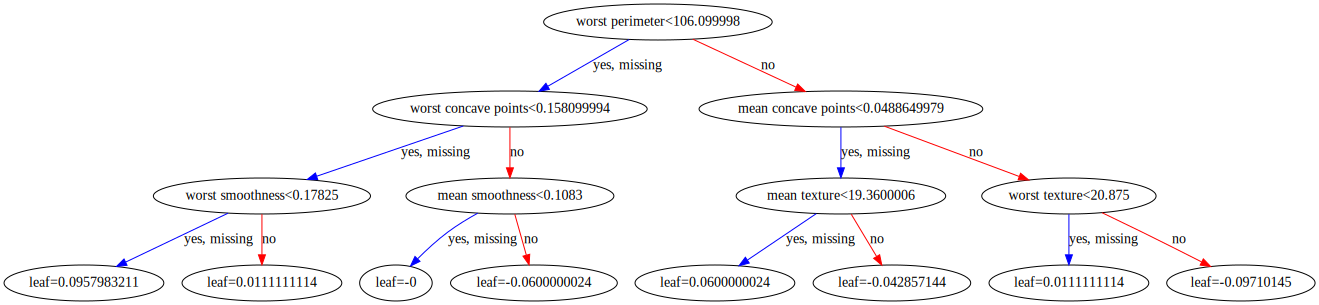

In [54]:
from xgboost import to_graphviz
to_graphviz(model)

In [55]:
from xgboost import XGBClassifier

In [56]:
model = XGBClassifier(n_estimators=500,learning_rate=0.05,max_depth=3,eval_metric='logloss')

In [57]:
model.fit(X_train,y_train,verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
pred = model.predict(X_test)

In [59]:
pred #결정값으로 나온다.

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [61]:
pred_proba = model.predict_proba(X_test)

In [62]:
pred_proba[:,1]

array([9.12188411e-01, 3.26777250e-03, 9.18584466e-01, 1.12425499e-01,
       9.91267264e-01, 9.99935985e-01, 9.99622345e-01, 9.99181807e-01,
       9.95988905e-01, 1.21930876e-04, 3.26498965e-04, 2.35663480e-04,
       9.99827325e-01, 9.99892950e-01, 9.98326719e-01, 9.92636442e-01,
       9.93933976e-01, 9.99863386e-01, 9.99317884e-01, 9.99371588e-01,
       7.17270304e-04, 6.14884675e-01, 2.00337556e-04, 9.99950290e-01,
       2.73418846e-04, 8.82554293e-01, 3.71223688e-03, 3.85174004e-04,
       9.98981297e-01, 4.70896214e-02, 9.98191297e-01, 4.11191548e-04,
       9.89034534e-01, 7.66591251e-01, 3.31286481e-03, 1.45611324e-04,
       9.98210073e-01, 9.98775661e-01, 2.10140735e-01, 9.99862194e-01,
       2.12053820e-01, 9.97596204e-01, 9.99571860e-01, 9.99598920e-01,
       9.99083996e-01, 9.84561980e-01, 1.25431782e-02, 9.99352515e-01,
       9.98489738e-01, 9.99605715e-01, 9.97448742e-01, 4.12069174e-04,
       9.99003828e-01, 9.99744356e-01, 9.99462426e-01, 9.99344289e-01,
      

In [65]:
 get_clf_eval(y_test,pred,pred_proba[:,1])

오차행렬
[[34  3]
 [ 1 76]]
정확도:0.9649, 정밀도:0.9620, 재현율:0.9870, F1:0.9744, AUC:0.9951


-교재 242p
eval - 검증셋?


In [72]:
model = XGBClassifier(n_estimators=500,learning_rate=0.05,max_depth=3)
evals=[(X_tr,y_tr),(X_val,y_val)]#리스트에 튜플로 구성 #검증에 쓸 것
model.fit(X_tr, #train중에 90:10 으로 나눈 것
          y_tr,
          verbose=True,
          eval_set=evals,
          early_stopping_rounds=50, #조기종료
          eval_metric='logloss') #평가
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)
get_clf_eval(y_test,pred,pred_proba[:,1])

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

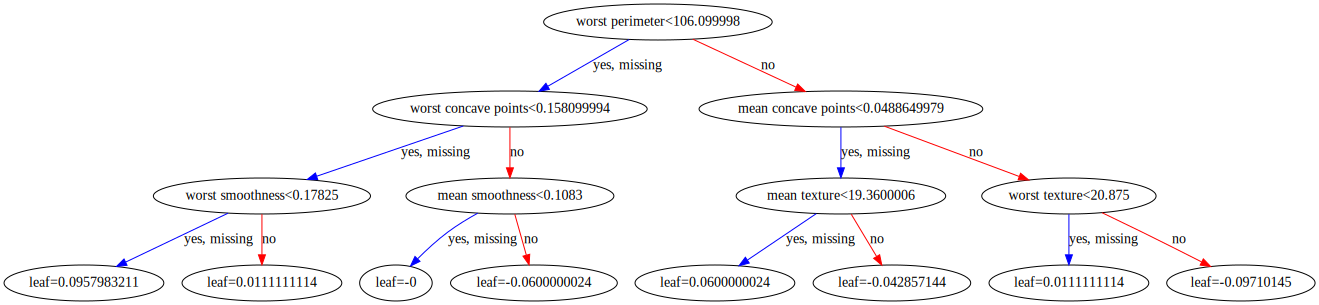

In [73]:
from xgboost import to_graphviz
to_graphviz(model)

조기종료가 너무 짧아도 좋진 않다. 
하이퍼파라미터튜닝 - GRIDSEACHCV

### LightGBM